# Step 1: Import Required Libraries

In this section, we import all the necessary libraries required for:
- Data handling (pandas, numpy)
- Visualization (matplotlib, seaborn)
- Survival analysis models (lifelines, sksurv)
- Data preprocessing (LabelEncoder, StandardScaler)

In [1]:
# Code Cell:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.inspection import permutation_importance


# Step 2: Load Dataset

We will load the dataset from the provided Excel file and perform an initial overview.

In [2]:
# Import the required libraries
import pandas as pd

# Code Cell:
file_path = "../Data/RADCURE_Clinical_v04_20241219.xlsx"
df = pd.read_excel(file_path, engine='openpyxl')

# Display first few rows
display(df.head())

# Show dataset information
df.info()


,patient_id,Age,Sex,ECOG PS,Smoking PY,Smoking Status,Ds Site,Subsite,T,N,...,Local,Date Local,Regional,Date Regional,Distant,Date Distant,2nd Ca,Date 2nd Ca,RADCURE-challenge,ContrastEnhanced
0,RADCURE-0005,62.6,Female,ECOG 0,50,Ex-smoker,Oropharynx,post wall,T4b,N2c,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,0
1,RADCURE-0006,87.3,Male,ECOG 2,25,Ex-smoker,Larynx,Glottis,T1b,N0,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,1
2,RADCURE-0007,49.9,Male,ECOG 1,15,Ex-smoker,Oropharynx,Tonsil,T3,N2b,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,1
3,RADCURE-0009,72.3,Male,ECOG 1,30,Ex-smoker,Unknown,NaN,T0,N2c,...,NaN,NaT,NaN,NaT,NaN,NaT,S (suspicious),2008-05-27,0,0
4,RADCURE-0010,59.7,Female,ECOG 0,0,Non-smoker,Oropharynx,Tonsillar Fossa,T4b,N0,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3346 entries, 0 to 3345
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   patient_id         3346 non-null   object        
 1   Age                3346 non-null   float64       
 2   Sex                3346 non-null   object        
 3   ECOG PS            3345 non-null   object        
 4   Smoking PY         3341 non-null   object        
 5   Smoking Status     3346 non-null   object        
 6   Ds Site            3346 non-null   object        
 7   Subsite            2972 non-null   object        
 8   T                  3334 non-null   object        
 9   N                  3333 non-null   object        
 10  M                  3332 non-null   object        
 11  Stage              3319 non-null   object        
 12  Path               3346 non-null   object        
 13  HPV                1717 non-null   object        
 14  Tx Modal

### Step 3: Data Preprocessing
We will clean the dataset by:
1. Selecting relevant columns.
2. Encoding categorical variables.
3. Creating new variables such as 'Event' and 'tage_Grouped'.
4. Standardizing numerical variables like 'Age'.

In [3]:
def preprocess_data(df):
    df['Event'] = df['Status'].apply(lambda x: 1 if x == 'Dead' else 0)
    columns_needed = ['Length FU', 'Event', 'Age', 'Sex', 'Smoking Status', 'Stage', 'Tx Modality']
    df_selected = df[columns_needed].dropna()

    # Bin Age into categories
    df_selected['Age_Binned'] = pd.cut(df_selected['Age'], bins=[0, 60, 100], labels=['Young-Mid', 'Older'])

    # Merge Stage into two broader categories
    df_selected['Stage_Grouped'] = df_selected['Stage'].apply(lambda x: 'Early' if x in ['I', 'II'] else 'Advanced')

    # Encode categorical variables
    label_encoders = {}
    for col in ['Sex', 'Smoking Status', 'Stage', 'Tx Modality', 'Age_Binned', 'Stage_Grouped']:
        df_selected[col] = df_selected[col].astype(str)
        le = LabelEncoder()  # Now LabelEncoder is defined
        df_selected[col] = le.fit_transform(df_selected[col])
        label_encoders[col] = le

    # Standardize Age
    scaler = StandardScaler()
    df_selected['Age'] = scaler.fit_transform(df_selected[['Age']])

    # ✅ Ensure 'Data' directory exists before saving
    if not os.path.exists("Data"):
        os.makedirs("Data")

    # Save processed data
    df_selected.to_csv("Data/Cleaned_Survival_Data.csv", index=False)
    print("Processed Data Saved: Data/Cleaned_Survival_Data.csv")

    return df_selected

# Process the data
df_selected = preprocess_data(df)

# Display processed data
display(df_selected.head())


Processed Data Saved: Data/Cleaned_Survival_Data.csv


,Length FU,Event,Age,Sex,Smoking Status,Stage,Tx Modality,Age_Binned,Stage_Grouped
0,1.317808,1,0.027446,0,1,11,4,0,0
1,1.520548,1,2.154306,1,1,1,4,0,1
2,2.126027,0,-1.066122,1,1,10,4,1,0
3,5.791781,0,0.862691,1,1,10,4,0,0
4,9.512329,0,-0.222266,0,2,11,4,1,0


### Step 4:Kaplan-Meier Survival Analysis
The Kaplan-Meier estimator is used to estimate survival probabilities over time.

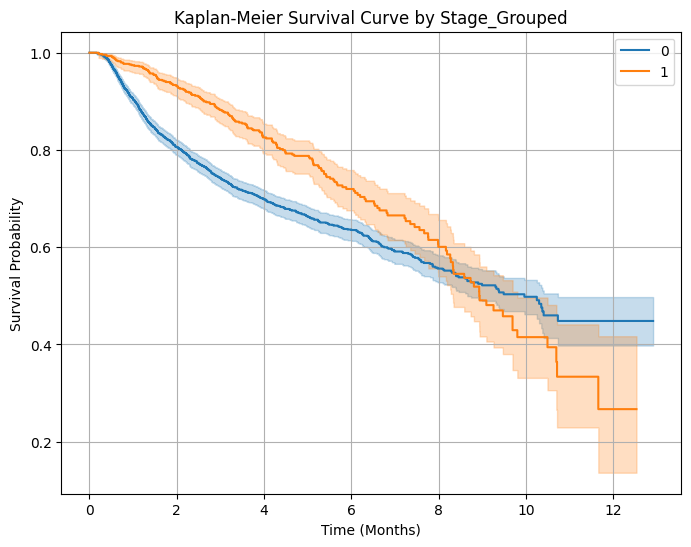

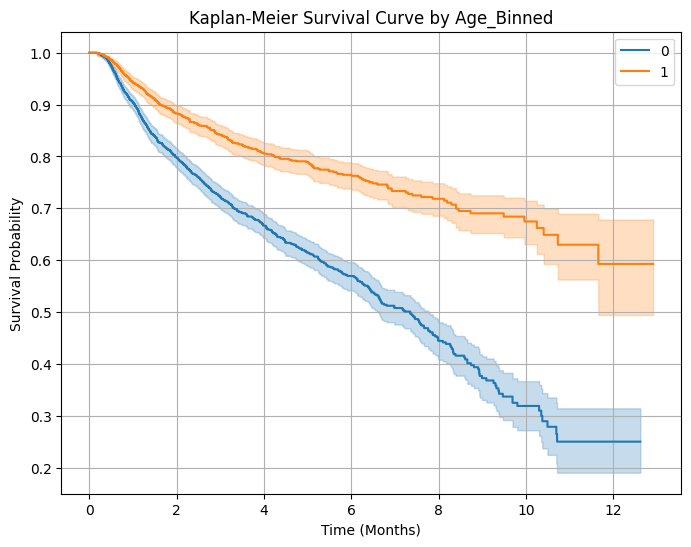

In [4]:
# Code Cell:
def plot_km_curve(df, strata_col):
    """Plots Kaplan-Meier Survival Curve for a given stratifying column"""
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(8,6))
    
    for cat in df[strata_col].unique():
        subset = df[df[strata_col] == cat]
        kmf.fit(subset['Length FU'], event_observed=subset['Event'], label=str(cat))
        kmf.plot_survival_function()

    plt.title(f"Kaplan-Meier Survival Curve by {strata_col}")
    plt.xlabel("Time (Months)")
    plt.ylabel("Survival Probability")
    plt.grid()
    plt.show()

# Plot KM curves
plot_km_curve(df_selected, strata_col='Stage_Grouped')
plot_km_curve(df_selected, strata_col='Age_Binned')


### Step 5: Log-Rank Test
The log-rank test checks if there is a statistically significant difference in survival between two groups.

In [5]:
# Code Cell:
def perform_logrank_test(df, group_col):
    """Performs log-rank test between two groups"""
    unique_groups = df[group_col].unique()
    
    if len(unique_groups) != 2:
        print(f"⚠️ Log-Rank test requires exactly 2 groups in '{group_col}', but found {len(unique_groups)}.")
        return

    group_1 = df[df[group_col] == unique_groups[0]]
    group_2 = df[df[group_col] == unique_groups[1]]

    results = logrank_test(group_1['Length FU'], group_2['Length FU'], 
                           event_observed_A=group_1['Event'], event_observed_B=group_2['Event'])
    
    print(f"📌 Log-Rank Test p-value for {group_col}: {results.p_value}")
    return results.p_value

# Perform Log-Rank Tests
perform_logrank_test(df_selected, group_col='Stage_Grouped')
perform_logrank_test(df_selected, group_col='Age_Binned')


📌 Log-Rank Test p-value for Stage_Grouped: 5.096569601138279e-06
📌 Log-Rank Test p-value for Age_Binned: 2.165032907557742e-31


np.float64(2.165032907557742e-31)

### Step 6: Cox Proportional Hazards Model
The Cox Model estimates the impact of multiple variables on survival.

<lifelines.CoxPHFitter: fitted with 3319 total observations, 2269 right-censored observations>
             duration col = 'Length FU'
                event col = 'Event'
                   strata = ['Age_Binned', 'Stage_Grouped']
      baseline estimation = breslow
   number of observations = 3319
number of events observed = 1050
   partial log-likelihood = -6519.63
         time fit was run = 2025-03-15 08:13:51 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
Age             0.49      1.64      0.06            0.38            0.60                1.47                1.83
Sex            -0.05      0.95      0.08           -0.20            0.10                0.82                1.11
Smoking Status -0.43      0.65      0.04           -0.51           -0.34                0.60                0.71
Stage           0.13      1.14      0.02            0.09            0.16                1.10                1.18
Tx Modality     0.16      1.18      0.02            0.12            0.20                1.13                1.23

                cmp to     z      p  -log2(p)
covariate                                    
Age               0.00  8.74 <0.005     58.56
Sex               0.00 -0.65   0.52      0.95
Smoking Status    0.00 -9.99 <0.005     75.68
Stage             0.00  7.13 <0.005     39.87
Tx Modality       0.00  8.12 <0.005     50.92
---
Concordance = 0.67
Partial AIC = 13049.26
log-likelihood ratio test = 343.93 on 5 df
-log2(p) of ll-ratio test = 237.35

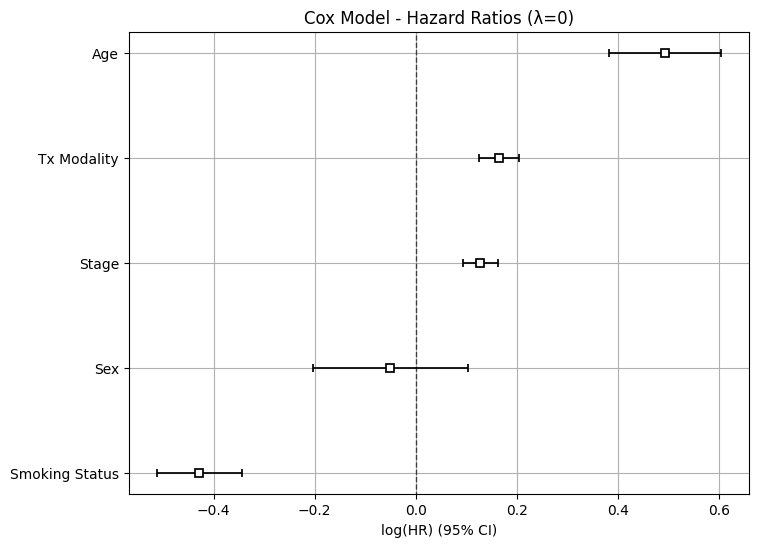

In [6]:
# Code Cell:
def run_cox_model(df, penalizer=0):
    """Runs Cox Proportional Hazards Model"""
    cph = CoxPHFitter(penalizer=penalizer)
    cph.fit(df, duration_col='Length FU', event_col='Event', strata=['Age_Binned', 'Stage_Grouped'])

    # Print Summary
    cph.print_summary()
    
    # Plot Hazard Ratios
    plt.figure(figsize=(8,6))
    cph.plot()
    plt.title(f"Cox Model - Hazard Ratios (λ={penalizer})")
    plt.grid()
    plt.show()

    return cph

# Run Cox Models
cox_standard = run_cox_model(df_selected, penalizer=0) # Standard Cox Model


<lifelines.CoxPHFitter: fitted with 3319 total observations, 2269 right-censored observations>
             duration col = 'Length FU'
                event col = 'Event'
                   strata = ['Age_Binned', 'Stage_Grouped']
      baseline estimation = breslow
   number of observations = 3319
number of events observed = 1050
   partial log-likelihood = -6519.63
         time fit was run = 2025-03-15 08:13:59 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
Age             0.49      1.64      0.06            0.38            0.60                1.47                1.83
Sex            -0.05      0.95      0.08           -0.20            0.10                0.82                1.11
Smoking Status -0.43      0.65      0.04           -0.51           -0.34                0.60                0.71
Stage           0.13      1.14      0.02            0.09            0.16                1.10                1.18
Tx Modality     0.16      1.18      0.02            0.12            0.20                1.13                1.23

                cmp to     z      p  -log2(p)
covariate                                    
Age               0.00  8.74 <0.005     58.56
Sex               0.00 -0.65   0.52      0.95
Smoking Status    0.00 -9.99 <0.005     75.68
Stage             0.00  7.13 <0.005     39.87
Tx Modality       0.00  8.12 <0.005     50.92
---
Concordance = 0.67
Partial AIC = 13049.26
log-likelihood ratio test = 343.93 on 5 df
-log2(p) of ll-ratio test = 237.35

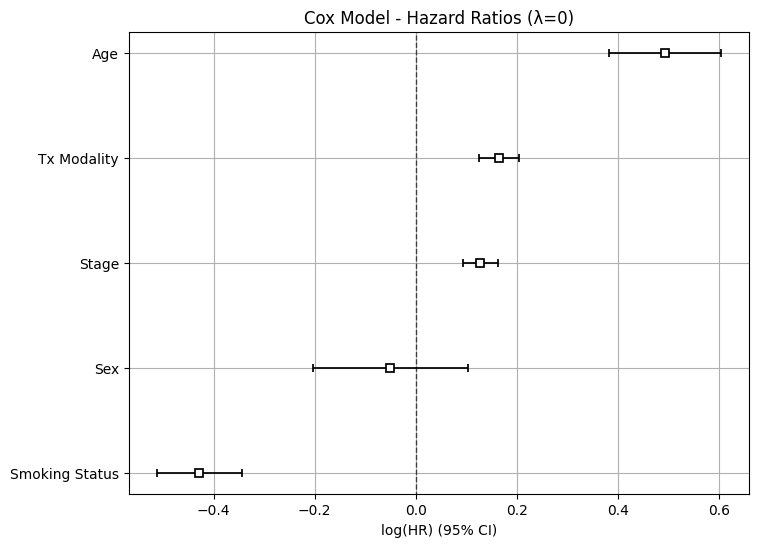

model,lifelines.CoxPHFitter
duration col,'Length FU'
event col,'Event'
penalizer,0.01
l1 ratio,0.0
strata,"[Age_Binned, Stage_Grouped]"
baseline estimation,breslow
number of observations,3319
number of events observed,1050
partial log-likelihood,-6529.76
time fit was run,2025-03-15 08:14:00 UTC


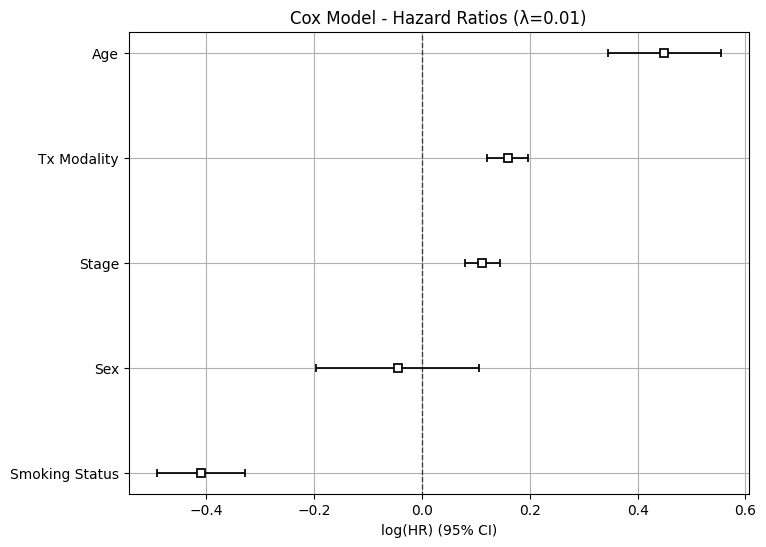

model,lifelines.CoxPHFitter
duration col,'Length FU'
event col,'Event'
penalizer,1.0
l1 ratio,0.0
strata,"[Age_Binned, Stage_Grouped]"
baseline estimation,breslow
number of observations,3319
number of events observed,1050
partial log-likelihood,-6661.33
time fit was run,2025-03-15 08:14:01 UTC


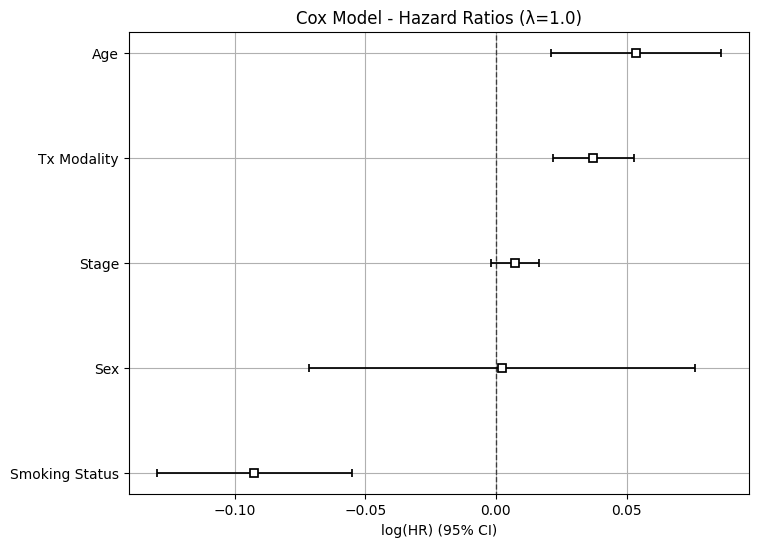

✅ All Cox Models Trained Successfully!


In [7]:
# Run Cox Models (Standard, Lasso, and Ridge)
cox_standard = run_cox_model(df_selected, penalizer=0)       # Standard Cox Model
cox_lasso = run_cox_model(df_selected, penalizer=0.01)       # Lasso (L1 Regularization)
cox_ridge = run_cox_model(df_selected, penalizer=1.0)        # Ridge (L2 Regularization)

print("✅ All Cox Models Trained Successfully!")


###  Step 7: Random Survival Forest (RSF) Model
A Random Survival Forest is trained to model nonlinear survival relationships.

In [8]:
# Code Cell:
def run_rsf_model(df):
    """Runs Random Survival Forest Model"""
    survival_labels = Surv.from_dataframe("Event", "Length FU", df)
    X = df.drop(columns=["Event", "Length FU"])

    rsf = RandomSurvivalForest(n_estimators=100, min_samples_leaf=10, max_features="log2", random_state=42)
    rsf.fit(X, survival_labels)

    print(f"📌 Random Survival Forest C-Index: {rsf.score(X, survival_labels):.4f}")

    return rsf

# Train RSF Model
rsf_model = run_rsf_model(df_selected)


📌 Random Survival Forest C-Index: 0.7642


### Final Summary & Comparison

In [10]:
from sklearn.inspection import permutation_importance

# Compute Permutation Importance for RSF Model (n_repeats=2 for faster execution)
survival_labels = Surv.from_dataframe("Event", "Length FU", df_selected)
X = df_selected.drop(columns=["Event", "Length FU"])

perm_importance = permutation_importance(
    rsf_model, X, survival_labels, n_repeats=2, random_state=42  # Reduced from 5 to 2
)
feature_importances = pd.Series(perm_importance.importances_mean, index=X.columns)

# Final Model Comparison
print("\n===== FINAL RESULTS: SURVIVAL ANALYSIS =====\n")

# Kaplan-Meier Summary
print("🟢 Kaplan-Meier Log-Rank Test Results:")
print(f"  - Log-Rank p-value for Stage_Grouped: {logrank_test(df_selected.loc[df_selected['Stage_Grouped'] == 0, 'Length FU'], df_selected.loc[df_selected['Stage_Grouped'] == 1, 'Length FU'], event_observed_A=df_selected.loc[df_selected['Stage_Grouped'] == 0, 'Event'], event_observed_B=df_selected.loc[df_selected['Stage_Grouped'] == 1, 'Event']).p_value}")
print(f"  - Log-Rank p-value for Age_Binned: {logrank_test(df_selected.loc[df_selected['Age_Binned'] == 0, 'Length FU'], df_selected.loc[df_selected['Age_Binned'] == 1, 'Length FU'], event_observed_A=df_selected.loc[df_selected['Age_Binned'] == 0, 'Event'], event_observed_B=df_selected.loc[df_selected['Age_Binned'] == 1, 'Event']).p_value}")
print("\n")

# Cox Model C-Index Comparison
print("🟢 Cox Proportional Hazards Model C-Indices:")
print(f"  - Standard Cox Model: {cox_standard.concordance_index_:.4f}")
print(f"  - Lasso Penalized Cox Model: {cox_lasso.concordance_index_:.4f}")
print(f"  - Ridge Penalized Cox Model: {cox_ridge.concordance_index_:.4f}")
print("\n")

# RSF Model C-Index
print("🟢 Random Survival Forest Model C-Index:")
print(f"  - RSF C-Index: {rsf_model.score(df_selected.drop(columns=['Event', 'Length FU']), Surv.from_dataframe('Event', 'Length FU', df_selected)):.4f}")
print("\n")

# Print Feature Importance (Top 5)
print("\n🟢 Top Predictive Features in RSF:")
print(feature_importances.sort_values(ascending=False).head(5))  # Show top 5 features

print("\n===== END OF STUDY RESULTS =====\n")



===== FINAL RESULTS: SURVIVAL ANALYSIS =====

🟢 Kaplan-Meier Log-Rank Test Results:
  - Log-Rank p-value for Stage_Grouped: 5.096569601138279e-06
  - Log-Rank p-value for Age_Binned: 2.165032907557742e-31


🟢 Cox Proportional Hazards Model C-Indices:
  - Standard Cox Model: 0.6650
  - Lasso Penalized Cox Model: 0.6646
  - Ridge Penalized Cox Model: 0.6495


🟢 Random Survival Forest Model C-Index:
  - RSF C-Index: 0.7642



🟢 Top Predictive Features in RSF:
Age               0.089636
Stage             0.080150
Smoking Status    0.069041
Tx Modality       0.045542
Age_Binned        0.017857
dtype: float64

===== END OF STUDY RESULTS =====

